In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
def basic_sampler(X,y,gamma_params=[1.,1.], lambda_param=1., mu0=None, K=None,num_iters=1000):
    #init
    
    num_obs, num_params = X.shape
    
    omegas = np.zeros(num_iters)
    lambs = np.zeros((num_obs,num_iters))
    betas = np.zeros((num_params,num_iters))
    omegas[0] = gamma_params[0]/gamma_params[1]
    lambs[:,0] = 1.
    if K is None:
        K = np.eye(num_params)
    if mu0 is None:
        mu0 = np.zeros(num_params)
    for iter in range(1,num_iters):
        #sample omega
        lamb = np.diag(lambs[:,iter-1])
        post_K = np.dot(X.T,np.dot(lamb,X))+K
        tmp = np.dot(X.T,np.dot(lamb,y))+np.dot(K,mu0)
        post_mu = np.dot(np.linalg.inv(post_K),tmp)
        post_gamma_1 = gamma_params[0]+num_obs/2
        post_gamma_2 = gamma_params[1]+ 0.5*np.dot(y,np.dot(lamb,y)) + \
                0.5*np.dot(mu0,np.dot(K,mu0))-0.5*np.dot(post_mu,np.dot(post_K,post_mu))
        
        omegas[iter]=np.random.gamma(post_gamma_1,1/post_gamma_2)
        betas[:,iter]= np.random.multivariate_normal(post_mu,np.linalg.inv(omegas[iter]*post_K))
        for n in range(num_obs):
            sq_diff = (y[i]-np.dot(betas[:,iter],X[n,:]))**2
            lambs[n,iter]=np.random.gamma(lambda_param+0.5,lambda_param + 0.5*omegas[iter]*sq_diff)
            
    return betas, omegas, lambs
            

In [2]:
import pandas as pd

df = pd.read_csv("/Users/williamsons/Teaching/GradCourse/R/dental.csv") #load data into pandas dataframe

#split data
y = df.as_matrix(columns=['distance']).ravel() 
X = df.as_matrix(columns=['age'])
X = np.hstack((np.ones((len(y),1)),X))
id_attribute_list = list(set(df['Subject'].values))
first_id = id_attribute_list.pop()
X = np.hstack((X,np.zeros((len(y),1+len(id_attribute_list)))))
X[:,2] = np.array(df['Sex'].values=='Male').astype(float)

for i in range(len(id_attribute_list)):
    X[:,i+3] = np.array(df['Subject']==id_attribute_list[i])


In [3]:
betas,omegas,lambs = basic_sampler(X,y)

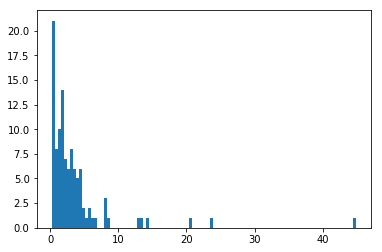

In [5]:
plt.hist(1/(omegas[-1]*lambs[:,-1]),100)
plt.show()

In [6]:
max(lambs[:,-1])

18.657774060819946

In [7]:
def grouped_variance_sampler(X,y,gamma_params=[1.,1.], lambda_param=1., mu0=None, K=None,num_iters=1000):
    #init
    
    num_obs, num_params = X.shape
    
    omegas = np.zeros(num_iters)
    lambs = np.zeros((num_obs,num_iters))
    betas = np.zeros((num_params,num_iters))
    omegas[0] = gamma_params[0]/gamma_params[1]
    lambs[:,0] = 1.
    if K is None:
        K = np.eye(num_params)
    if mu0 is None:
        mu0 = np.zeros(num_params)
    for iter in range(1,num_iters):
        #sample omega
        lamb = np.diag(lambs[:,iter-1])
        post_K = np.dot(X.T,np.dot(lamb,X))+K
        tmp = np.dot(X.T,np.dot(lamb,y))+np.dot(K,mu0)
        post_mu = np.dot(np.linalg.inv(post_K),tmp)
        post_gamma_1 = gamma_params[0]+num_obs/2
        post_gamma_2 = gamma_params[1]+ 0.5*np.dot(y,np.dot(lamb,y)) + \
                0.5*np.dot(mu0,np.dot(K,mu0))-0.5*np.dot(post_mu,np.dot(post_K,post_mu))
        
        omegas[iter]=np.random.gamma(post_gamma_1,1/post_gamma_2)
        betas[:,iter]= np.random.multivariate_normal(post_mu,np.linalg.inv(omegas[iter]*post_K))
        male_inds = np.where(X[:,3]==1)[0]
        female_inds = np.where(X[:,3]==0)[0]
        
        num_m = len(male_inds)
        num_f = len(female_inds)
        diff_m = y[male_inds]-np.dot(X[male_inds,:],betas[:,iter])
        m_sq_diff = np.dot(diff_m,diff_m)
        diff_f = y[female_inds]-np.dot(X[female_inds,:],betas[:,iter])
        f_sq_diff = np.dot(diff_f,diff_f)
        lamb_male = np.random.gamma(lambda_param+num_m/2, lambda_param+0.5*omegas[iter]*m_sq_diff)
        lamb_female = np.random.gamma(lambda_param+num_f/2, lambda_param+0.5*omegas[iter]*f_sq_diff)
        lambs[male_inds,iter]+=lamb_male
        lambs[female_inds,iter]+=lamb_female
        
    return betas, omegas, lambs

In [8]:
betas2,omegas2,lambs2 = grouped_variance_sampler(X,y)

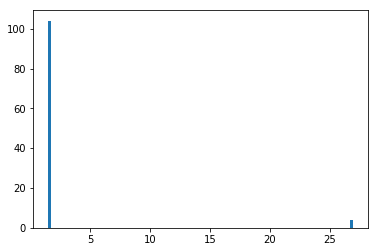

In [9]:
plt.hist(1/(omegas2[-1]*lambs2[:,-1]),100)
plt.show()

In [10]:
y_pred_1 = np.dot(X,betas[:,-1])

In [11]:
y_pred_2 = np.dot(X,betas[:,-2])

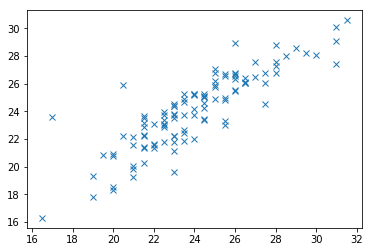

In [12]:
plt.plot(y,y_pred_1,'x')
plt.show()

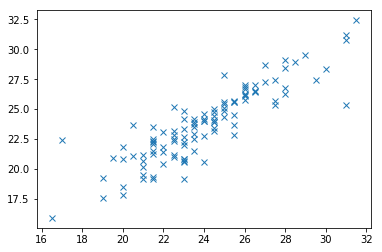

In [13]:
plt.plot(y,y_pred_2,'x')
plt.show()

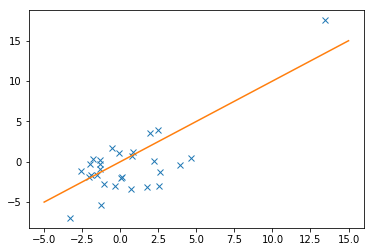

In [14]:
plt.plot(betas[:,-1],betas2[:,-1],'x')
plt.plot([-5,15],[-5,15])
plt.show()

In [15]:
resids1 = y-np.dot(X,betas[:,-1])
resids2 = y-np.dot(X,betas2[:,-1])


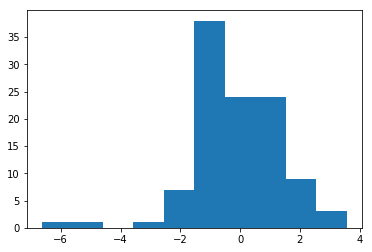

In [16]:
plt.hist(resids1)
plt.show()

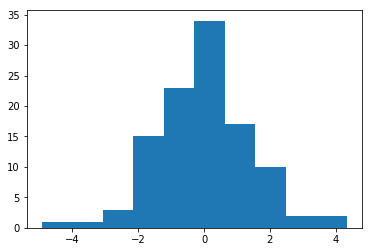

In [17]:
plt.hist(resids2)
plt.show()